In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data import CCV1
from torch_geometric.data import DataLoader 
from imports.models import Net_SEC, Net_GAT, Net_Trans
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
data_path = '/vols/cms/mm1221/Data/mix/test/raw/test.root' 
data_file = uproot.open(data_path)
LC_x = data_file['clusters']['position_x'].array()
pgid = data_file['simtrackstersCP']['pdgID'].array()
skim_mask = []
for e in LC_x:
    if 1 <= len(e):
        skim_mask.append(True)
    else:
        skim_mask.append(False)
        
pgid = pgid[skim_mask]


In [3]:
data_path = '/vols/cms/mm1221/Data/mix/test/raw/test.root' 
data_file = uproot.open(data_path)
bc_x = data_file['tracksters']['barycenter_x'].array()
pgid1 = data_file['simtrackstersCP']['pdgID'].array()
skim_mask = []
for e in bc_x:
    if 1 <= len(e):
        skim_mask.append(True)
    else:
        skim_mask.append(False)
        
pgid1 = pgid1[skim_mask]


In [7]:
import pandas as pd

df_DEC = pd.read_csv("csvMix/df_DE_mix_0175.csv")
df_Trans = pd.read_csv("csvMix/df_Trans_mix_0175.csv")
df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")

df_DEC_e = pd.read_csv("csvElectron/df_DE_e_0175.csv")
df_Trans_e = pd.read_csv("csvElectron/df_Trans_e_0175.csv")
df_MT_e = pd.read_csv("csvElectron/df_TICL_MT_elec.csv")




In [8]:
df_Trans['pgid'] = df_Trans.apply(lambda row: pgid1[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_MT['pgid'] = df_MT.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_DEC['pgid'] = df_DEC.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)



/tmp/ipykernel_805191/411643010.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_805191/411643010.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_805191/411643010.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

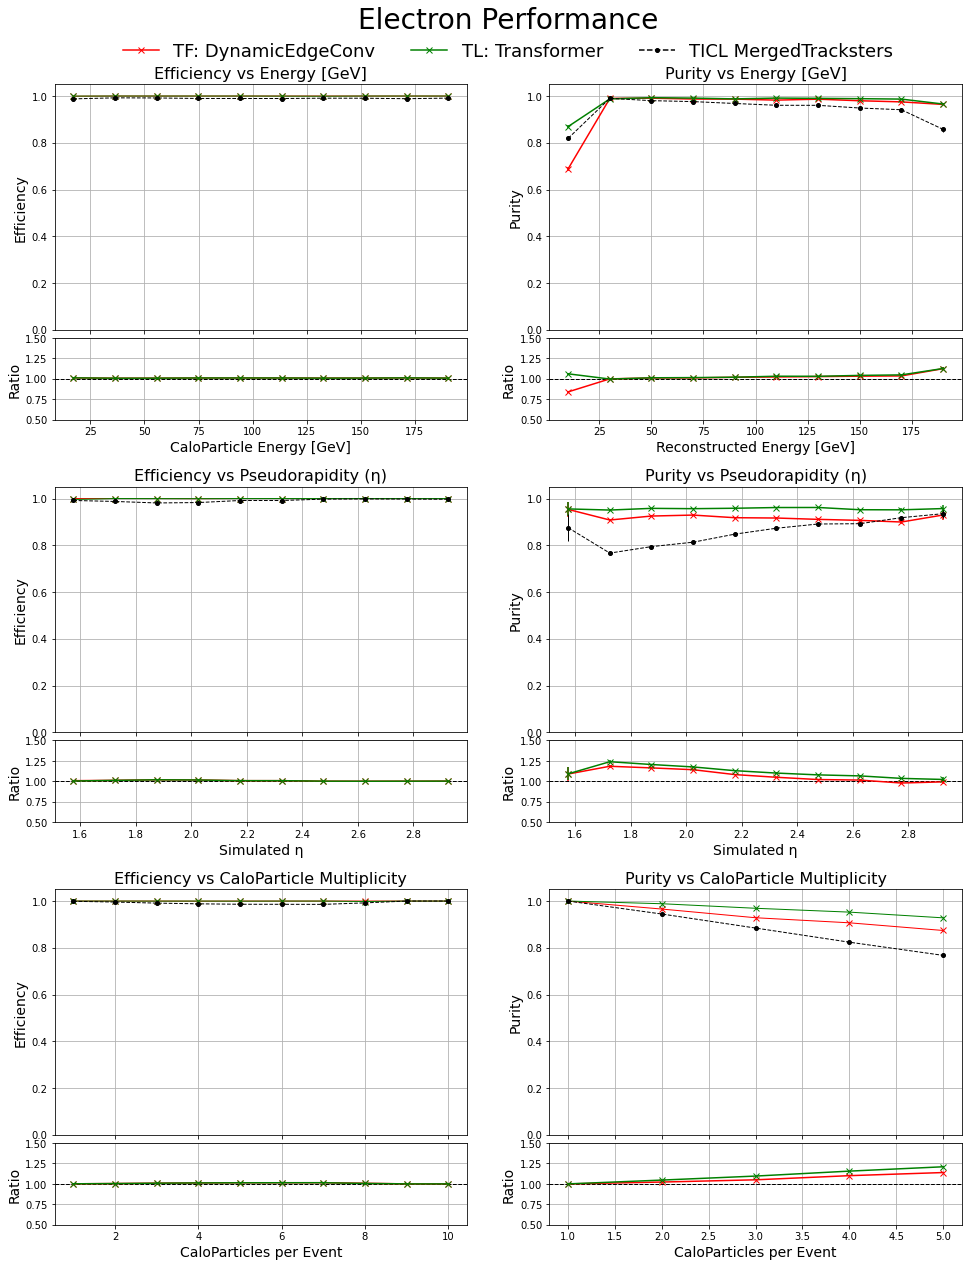

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

###############################################################################
# 0. LOAD NEW DATAFRAMES
###############################################################################
###############################################################################
# 1. ENERGY-BASED DATA PREPARATION
###############################################################################
# Efficiency from CaloParticle data
model_dfs_all_energy = {
    "TF: DynamicEdgeConv": df_DEC,
    "TL: Transformer": df_Trans,
    "TICL MergedTracksters": df_MT
}

for name, df in model_dfs_all_energy.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    # Only keep events with pgid in [11,-11]
    model_dfs_all_energy[name] = df[df['pgid'].isin([11, -11])]

def prepare_cp_data_energy(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max'
    }).reset_index()
    # A reconstruction is considered good if shared_energy >= 50% of cp_energy
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

model_prepared_all_energy = {name: prepare_cp_data_energy(df)
                             for name, df in model_dfs_all_energy.items()}

# Energy binning (using all cp_energy values)
all_energies = pd.concat([df['cp_energy'] for df in model_prepared_all_energy.values()])
min_energy = all_energies.min()
max_energy = 200
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

for df in model_prepared_all_energy.values():
    df['energy_bin'] = pd.cut(df['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

def aggregate_efficiency(df):
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all_energy = {name: aggregate_efficiency(df) for name, df in model_prepared_all_energy.items()}

# Final efficiency dictionary
model_efficiency = {
    "TF: DynamicEdgeConv": eff_all_energy["TF: DynamicEdgeConv"],
    "TL: Transformer": eff_all_energy["TL: Transformer"],
    "TICL MergedTracksters": eff_all_energy["TICL MergedTracksters"]
}

# Purity from electron trackster data (energy version)
model_dfs_e_all_energy = {
    "TF: DynamicEdgeConv": df_DEC_e,
    "TL: Transformer": df_Trans_e,
    "TICL MergedTracksters": df_MT_e
}

def prepare_trackster_data_energy(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    # An association is defined if reco_to_sim_score < 0.2
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

prepared_dfs_e_all_energy = {name: prepare_trackster_data_energy(df)
                             for name, df in model_dfs_e_all_energy.items()}

# Use same energy binning for tracksters
all_energies_e = pd.concat([df['trackster_energy'] for df in prepared_dfs_e_all_energy.values()])
min_energy_e = all_energies_e.min()
max_energy_e = 200
energy_bins_e = np.linspace(min_energy_e, max_energy_e, n_bins + 1)
bin_centers_e = 0.5 * (energy_bins_e[:-1] + energy_bins_e[1:])

for df in prepared_dfs_e_all_energy.values():
    df['energy_bin'] = pd.cut(df['trackster_energy'], bins=energy_bins_e, labels=False, include_lowest=True)

def aggregate_purity(df):
    agg = df.groupby('energy_bin').agg(
        total_ts=('trackster_energy', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_energy = {name: aggregate_purity(df) for name, df in prepared_dfs_e_all_energy.items()}

model_purity = {
    "TF: DynamicEdgeConv": pur_all_energy["TF: DynamicEdgeConv"],
    "TL: Transformer": pur_all_energy["TL: Transformer"],
    "TICL MergedTracksters": pur_all_energy["TICL MergedTracksters"]
}

###############################################################################
# 2. ETA-BASED DATA PREPARATION
###############################################################################
# Efficiency vs. η from CaloParticle data
model_dfs_all_eta = {
    "TF: DynamicEdgeConv": df_DEC,
    "TL: Transformer": df_Trans,
    "TICL MergedTracksters": df_MT
}

for name, df in model_dfs_all_eta.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')
    model_dfs_all_eta[name] = df[df['pgid'].isin([11, -11])]

def prepare_cp_data_eta(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'cp_eta': 'first',
        'shared_energy': 'max'
    }).reset_index()
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

model_prepared_all_eta = {name: prepare_cp_data_eta(df) for name, df in model_dfs_all_eta.items()}

# η binning: using range 1.5 to 3.0 in 10 bins
min_eta = 1.5
max_eta = 3.0
n_eta_bins = 10
eta_bins = np.linspace(min_eta, max_eta, n_eta_bins + 1)
eta_centers = (eta_bins[:-1] + eta_bins[1:]) / 2

for df in model_prepared_all_eta.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

def aggregate_efficiency_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all_eta = {name: aggregate_efficiency_eta(df) for name, df in model_prepared_all_eta.items()}

model_efficiency_eta = {
    "TF: DynamicEdgeConv": eff_all_eta["TF: DynamicEdgeConv"],
    "TL: Transformer": eff_all_eta["TL: Transformer"],
    "TICL MergedTracksters": eff_all_eta["TICL MergedTracksters"]
}

# Purity vs. η from electron trackster data
model_dfs_e_all_eta = {
    "TF: DynamicEdgeConv": df_DEC_e,
    "TL: Transformer": df_Trans_e,
    "TICL MergedTracksters": df_MT_e
}

def prepare_trackster_data_eta(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')  # assuming this column exists
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'cp_eta': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

model_prepared_e_eta = {name: prepare_trackster_data_eta(df) for name, df in model_dfs_e_all_eta.items()}

for df in model_prepared_e_eta.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

def aggregate_purity_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_ts=('cp_eta', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_eta = {name: aggregate_purity_eta(df) for name, df in model_prepared_e_eta.items()}

model_purity_eta = {
    "TF: DynamicEdgeConv": pur_all_eta["TF: DynamicEdgeConv"],
    "TL: Transformer": pur_all_eta["TL: Transformer"],
    "TICL MergedTracksters": pur_all_eta["TICL MergedTracksters"]
}

###############################################################################
# 3. nCP-BASED DATA PREPARATION
###############################################################################
# Efficiency vs. CaloParticle Multiplicity
model_dfs_all_ncp = {
    "TF: DynamicEdgeConv": df_DEC,
    "TL: Transformer": df_Trans,
    "TICL MergedTracksters": df_MT
}

for name, df in model_dfs_all_ncp.items():
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    df = df[df['pgid'].isin([11, -11])]
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max',
        'n_cp': 'first'
    }).reset_index()
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    model_dfs_all_ncp[name] = grouped

def aggregate_efficiency_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_cp=('cp_id', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all_ncp = {name: aggregate_efficiency_ncp(df) for name, df in model_dfs_all_ncp.items()}

model_efficiency_ncp = {
    "TF: DynamicEdgeConv": eff_all_ncp["TF: DynamicEdgeConv"],
    "TL: Transformer": eff_all_ncp["TL: Transformer"],
    "TICL MergedTracksters": eff_all_ncp["TICL MergedTracksters"]
}

# Purity vs. CaloParticle Multiplicity from electron trackster data
model_dfs_e_all_ncp = {
    "TF: DynamicEdgeConv": df_DEC_e,
    "TL: Transformer": df_Trans_e,
    "TICL MergedTracksters": df_MT_e
}

def prepare_trackster_data_ncp(df):
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'reco_to_sim_score': 'min',
        'n_cp': 'first'
    }).reset_index()
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

model_prepared_e_ncp = {name: prepare_trackster_data_ncp(df) for name, df in model_dfs_e_all_ncp.items()}

def aggregate_purity_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_ts=('trackster_id', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_ncp = {name: aggregate_purity_ncp(df) for name, df in model_prepared_e_ncp.items()}

model_purity_ncp = {
    "TF: DynamicEdgeConv": pur_all_ncp["TF: DynamicEdgeConv"],
    "TL: Transformer": pur_all_ncp["TL: Transformer"],
    "TICL MergedTracksters": pur_all_ncp["TICL MergedTracksters"]
}

###############################################################################
# 4. COMBINED PLOTTING
###############################################################################
# Define colour mappings (for all plot types)
eff_colors_energy = {
    "TF: DynamicEdgeConv": "red",
    "TL: Transformer": "green",
    "TICL MergedTracksters": "black"
}
pur_colors_energy = eff_colors_energy.copy()
eff_colors_eta = eff_colors_energy.copy()
pur_colors_eta = eff_colors_energy.copy()
eff_colors_ncp = eff_colors_energy.copy()
pur_colors_ncp = eff_colors_energy.copy()

# Create the outer figure with 3 rows (for Energy, η, and Multiplicity) and 2 columns (Efficiency, Purity)
fig = plt.figure(figsize=(14, 18))
outer_gs = gridspec.GridSpec(nrows=3, ncols=2, hspace=0.2, wspace=0.2)

#### Row 0: Energy-Based Plots ####
# Left: Efficiency vs. Energy with ratio subplot
gs0_left = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.05)
ax0_eff = fig.add_subplot(gs0_left[0])
ax0_eff_ratio = fig.add_subplot(gs0_left[1], sharex=ax0_eff)
for key, agg in model_efficiency.items():
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = eff_colors_energy[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = eff_colors_energy[key]; lw = 1; ms = 6
    ax0_eff.errorbar(bin_centers, agg['efficiency'], yerr=agg['eff_error'],
                     marker=marker, linestyle=ls, linewidth=lw,
                     markersize=ms, color=color)
ax0_eff.set_title("Efficiency vs Energy [GeV]", fontsize=16)
ax0_eff.set_ylabel('Efficiency', fontsize=14)
ax0_eff.set_ylim(0, 1.05)
ax0_eff.grid(True)
ax0_eff.tick_params(labelbottom=False)

ref_eff = model_efficiency["TICL MergedTracksters"]
ref_val = ref_eff['efficiency'].replace(0, np.nan)
ref_err = ref_eff['eff_error']
for key, agg in model_efficiency.items():
    if key == "TICL MergedTracksters":
        continue
    ratio = agg['efficiency'] / ref_val
    ratio_err = ratio * np.sqrt((agg['eff_error']/agg['efficiency'])**2 +
                                (ref_err/ref_val)**2)
    ax0_eff_ratio.errorbar(bin_centers, ratio, yerr=ratio_err,
                           marker="x", linestyle="-", linewidth=1.5, markersize=6,
                           color=eff_colors_energy[key])
ax0_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax0_eff_ratio.set_xlabel('CaloParticle Energy [GeV]', fontsize=14)
ax0_eff_ratio.set_ylabel('Ratio', fontsize=14)
ax0_eff_ratio.set_ylim(0.5, 1.5)
ax0_eff_ratio.grid(True)

# Right: Purity vs. Energy
gs0_right = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax0_pur = fig.add_subplot(gs0_right[0])
ax0_pur_ratio = fig.add_subplot(gs0_right[1], sharex=ax0_pur)
for key, agg in model_purity.items():
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = pur_colors_energy[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = pur_colors_energy[key]; lw = 1.5; ms = 6
    ax0_pur.errorbar(bin_centers_e, agg['purity'], yerr=agg['purity_error'],
                     marker=marker, linestyle=ls, linewidth=lw, markersize=ms, color=color)
ax0_pur.set_title("Purity vs Energy [GeV]", fontsize=16)
ax0_pur.set_ylabel('Purity', fontsize=14)
ax0_pur.set_ylim(0, 1.05)
ax0_pur.grid(True)
ax0_pur.tick_params(labelbottom=False)
ref_pur = model_purity["TICL MergedTracksters"]
ref_val_pur = ref_pur['purity'].replace(0, np.nan)
ref_err_pur = ref_pur['purity_error']
for key, agg in model_purity.items():
    if key == "TICL MergedTracksters":
        continue
    ratio = agg['purity'] / ref_val_pur
    ratio_err = ratio * np.sqrt((agg['purity_error']/agg['purity'])**2 +
                                (ref_err_pur/ref_val_pur)**2)
    ax0_pur_ratio.errorbar(bin_centers_e, ratio, yerr=ratio_err,
                           marker="x", linestyle="-", linewidth=1.5, markersize=6,
                           color=pur_colors_energy[key])
ax0_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax0_pur_ratio.set_xlabel('Reconstructed Energy [GeV]', fontsize=14)
ax0_pur_ratio.set_ylabel('Ratio', fontsize=14)
ax0_pur_ratio.set_ylim(0.5, 1.5)
ax0_pur_ratio.grid(True)

#### Row 1: η-Based Plots ####
# Left: Efficiency vs. Pseudorapidity (η)
gs1_left = outer_gs[1, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax1_eff = fig.add_subplot(gs1_left[0])
ax1_eff_ratio = fig.add_subplot(gs1_left[1], sharex=ax1_eff)
for key, agg in model_efficiency_eta.items():
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = eff_colors_eta[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = eff_colors_eta[key]; lw = 1; ms = 6
    ax1_eff.errorbar(eta_centers, agg['efficiency'], yerr=agg['eff_error'],
                     marker=marker, linestyle=ls, linewidth=lw,
                     markersize=ms, color=color)
ax1_eff.set_title("Efficiency vs Pseudorapidity (η)", fontsize=16)
ax1_eff.set_ylabel('Efficiency', fontsize=14)
ax1_eff.set_ylim(0, 1.05)
ax1_eff.grid(True)
ax1_eff.tick_params(labelbottom=False)

ref_eff_eta = model_efficiency_eta["TICL MergedTracksters"]
ref_val_eta = ref_eff_eta['efficiency'].replace(0, np.nan)
ref_err_eta = ref_eff_eta['eff_error']
for key, agg in model_efficiency_eta.items():
    if key == "TICL MergedTracksters":
        continue
    ratio = agg['efficiency'] / ref_val_eta
    ratio_err = ratio * np.sqrt((agg['eff_error']/agg['efficiency'])**2 +
                                (ref_err_eta/ref_val_eta)**2)
    ax1_eff_ratio.errorbar(eta_centers, ratio, yerr=ratio_err,
                           marker="x", linestyle="-", linewidth=1.5, markersize=6,
                           color=eff_colors_eta[key])
ax1_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax1_eff_ratio.set_xlabel('Simulated η', fontsize=14)
ax1_eff_ratio.set_ylabel('Ratio', fontsize=14)
ax1_eff_ratio.set_ylim(0.5, 1.5)
ax1_eff_ratio.grid(True)

# Right: Purity vs. Pseudorapidity (η)
gs1_right = outer_gs[1, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax1_pur = fig.add_subplot(gs1_right[0])
ax1_pur_ratio = fig.add_subplot(gs1_right[1], sharex=ax1_pur)
for key, agg in model_purity_eta.items():
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = pur_colors_eta[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = pur_colors_eta[key]; lw = 1.5; ms = 6
    ax1_pur.errorbar(eta_centers, agg['purity'], yerr=agg['purity_error'],
                     marker=marker, linestyle=ls, linewidth=lw,
                     markersize=ms, color=color)
ax1_pur.set_title("Purity vs Pseudorapidity (η)", fontsize=16)
ax1_pur.set_ylabel('Purity', fontsize=14)
ax1_pur.set_ylim(0, 1.05)
ax1_pur.grid(True)
ax1_pur.tick_params(labelbottom=False)
ref_pur_eta = model_purity_eta["TICL MergedTracksters"]
ref_val_p_eta = ref_pur_eta['purity'].replace(0, np.nan)
ref_err_p_eta = ref_pur_eta['purity_error']
for key, agg in model_purity_eta.items():
    if key == "TICL MergedTracksters":
        continue
    ratio = agg['purity'] / ref_val_p_eta
    ratio_err = ratio * np.sqrt((agg['purity_error']/agg['purity'])**2 +
                                (ref_err_p_eta/ref_val_p_eta)**2)
    ax1_pur_ratio.errorbar(eta_centers, ratio, yerr=ratio_err,
                           marker="x", linestyle="-", linewidth=1.5, markersize=6,
                           color=pur_colors_eta[key])
ax1_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax1_pur_ratio.set_xlabel('Simulated η', fontsize=14)
ax1_pur_ratio.set_ylabel('Ratio', fontsize=14)
ax1_pur_ratio.set_ylim(0.5, 1.5)
ax1_pur_ratio.grid(True)

#### Row 2: nCP-Based Plots ####
# Left: Efficiency vs. CaloParticle Multiplicity
gs2_left = outer_gs[2, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax2_eff = fig.add_subplot(gs2_left[0])
ax2_eff_ratio = fig.add_subplot(gs2_left[1], sharex=ax2_eff)
for key, df_agg in model_efficiency_ncp.items():
    df_sorted = df_agg.sort_values('n_cp')
    xvals = df_sorted['n_cp']
    yvals = df_sorted['efficiency']
    yerr  = df_sorted['eff_error']
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = eff_colors_ncp[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = eff_colors_ncp[key]; lw = 1; ms = 6
    ax2_eff.errorbar(xvals, yvals, yerr=yerr, marker=marker, linestyle=ls,
                     linewidth=lw, markersize=ms, color=color)
ax2_eff.set_title("Efficiency vs CaloParticle Multiplicity", fontsize=16)
ax2_eff.set_ylabel('Efficiency', fontsize=14)
ax2_eff.set_ylim(0, 1.05)
ax2_eff.grid(True)
ax2_eff.tick_params(labelbottom=False)

ref_df_eff = model_efficiency_ncp["TICL MergedTracksters"].sort_values('n_cp')
for key, df_agg in model_efficiency_ncp.items():
    if key == "TICL MergedTracksters":
        continue
    df_sorted = df_agg.sort_values('n_cp')
    merged = pd.merge(df_sorted, ref_df_eff, on='n_cp', suffixes=('', '_ref'))
    xvals  = merged['n_cp']
    num_val  = merged['efficiency']
    num_err  = merged['eff_error']
    den_val  = merged['efficiency_ref'].replace(0, np.nan)
    den_err  = merged['eff_error_ref']
    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)
    ax2_eff_ratio.errorbar(xvals, ratio, yerr=ratio_err, marker="x",
                           linestyle="-", linewidth=1.5, markersize=6,
                           color=eff_colors_ncp[key])
ax2_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2_eff_ratio.set_xlabel('CaloParticles per Event', fontsize=14)
ax2_eff_ratio.set_ylabel('Ratio', fontsize=14)
ax2_eff_ratio.set_ylim(0.5, 1.5)
ax2_eff_ratio.grid(True)

# Right: Purity vs. CaloParticle Multiplicity
gs2_right = outer_gs[2, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax2_pur = fig.add_subplot(gs2_right[0])
ax2_pur_ratio = fig.add_subplot(gs2_right[1], sharex=ax2_pur)
for key, df_agg in model_purity_ncp.items():
    df_sorted = df_agg.sort_values('n_cp')
    xvals = df_sorted['n_cp']
    yvals = df_sorted['purity']
    yerr  = df_sorted['purity_error']
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = pur_colors_ncp[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = pur_colors_ncp[key]; lw = 1; ms = 6
    ax2_pur.errorbar(xvals, yvals, yerr=yerr, marker=marker, linestyle=ls,
                     linewidth=lw, markersize=ms, color=color)
ax2_pur.set_title("Purity vs CaloParticle Multiplicity", fontsize=16)
ax2_pur.set_ylabel('Purity', fontsize=14)
ax2_pur.set_ylim(0, 1.05)
ax2_pur.grid(True)
ax2_pur.tick_params(labelbottom=False)
ref_df_pur = model_purity_ncp["TICL MergedTracksters"].sort_values('n_cp')
for key, df_agg in model_purity_ncp.items():
    if key == "TICL MergedTracksters":
        continue
    df_sorted = df_agg.sort_values('n_cp')
    merged = pd.merge(df_sorted, ref_df_pur, on='n_cp', suffixes=('', '_ref'))
    xvals  = merged['n_cp']
    num_val  = merged['purity']
    num_err  = merged['purity_error']
    den_val  = merged['purity_ref'].replace(0, np.nan)
    den_err  = merged['purity_error_ref']
    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)
    ax2_pur_ratio.errorbar(xvals, ratio, yerr=ratio_err, marker="x",
                           linestyle="-", linewidth=1.5, markersize=6,
                           color=pur_colors_ncp[key])
ax2_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2_pur_ratio.set_xlabel('CaloParticles per Event', fontsize=14)
ax2_pur_ratio.set_ylabel('Ratio', fontsize=14)
ax2_pur_ratio.set_ylim(0.5, 1.5)
ax2_pur_ratio.grid(True)

###############################################################################
# 5. GLOBAL TITLE, LEGEND, AND FINAL LAYOUT ADJUSTMENTS
###############################################################################
fig.suptitle("Electron Performance", fontsize=28, y=0.99)

# Global legend using custom line objects
legend_elements = [
    Line2D([0], [0], marker="x", color="red", linestyle="-", markersize=6, label="TF: DynamicEdgeConv"),
    Line2D([0], [0], marker="x", color="green", linestyle="-", markersize=6, label="TL: Transformer"),
    Line2D([0], [0], marker="o", color="black", linestyle="--", markersize=4, label="TICL MergedTracksters")
]
fig.legend(handles=legend_elements, loc="upper center", ncol=3, frameon=False, fontsize=18, bbox_to_anchor=(0.5, 0.975))

fig.subplots_adjust(top=0.93, bottom=0.05, left=0.05, right=0.95)
plt.savefig("ElecPerf.pdf")
plt.show()


In [13]:
def compute_ratios(metric_dict, reference_key="TICL MergedTracksters", value_col="efficiency", error_col="eff_error", x_label="x"):
    ratios = {}
    ref = metric_dict[reference_key].copy()
    ref_val = ref[value_col].replace(0, np.nan)
    ref_err = ref[error_col]
    ref_x = ref[x_label] if x_label in ref else ref.index

    for key, df in metric_dict.items():
        if key == reference_key:
            continue
        df = df.copy()
        if x_label in df:
            merged = pd.merge(df, ref[[x_label, value_col, error_col]],
                              on=x_label, suffixes=('', '_ref'))
            xvals = merged[x_label]
            num_val = merged[value_col]
            num_err = merged[error_col]
            den_val = merged[f"{value_col}_ref"].replace(0, np.nan)
            den_err = merged[f"{error_col}_ref"]
        else:
            xvals = df.index
            num_val = df[value_col]
            num_err = df[error_col]
            den_val = ref_val
            den_err = ref_err

        ratio = num_val / den_val
        ratio_err = ratio * np.sqrt((num_err / num_val)**2 + (den_err / den_val)**2)

        ratios[key] = pd.DataFrame({
            x_label: xvals,
            'ratio': ratio,
            'ratio_err': ratio_err
        })

    return ratios

# Add bin centers to the corresponding DataFrames for clarity
for df in model_efficiency.values():
    df['energy_bin_center'] = bin_centers[df['energy_bin'].fillna(0).astype(int)]
for df in model_purity.values():
    df['energy_bin_center'] = bin_centers_e[df['energy_bin'].fillna(0).astype(int)]
for df in model_efficiency_eta.values():
    df['eta_bin_center'] = eta_centers[df['eta_bin'].fillna(0).astype(int)]
for df in model_purity_eta.values():
    df['eta_bin_center'] = eta_centers[df['eta_bin'].fillna(0).astype(int)]

# Compute ratios
ratios_all = {
    "Efficiency vs Energy": compute_ratios(model_efficiency, x_label='energy_bin_center'),
    "Purity vs Energy": compute_ratios(model_purity, value_col="purity", error_col="purity_error", x_label='energy_bin_center'),
    "Efficiency vs Eta": compute_ratios(model_efficiency_eta, x_label='eta_bin_center'),
    "Purity vs Eta": compute_ratios(model_purity_eta, value_col="purity", error_col="purity_error", x_label='eta_bin_center'),
    "Efficiency vs nCP": compute_ratios(model_efficiency_ncp, x_label='n_cp'),
    "Purity vs nCP": compute_ratios(model_purity_ncp, value_col="purity", error_col="purity_error", x_label='n_cp')
}

# Print output
for plot_title, model_dict in ratios_all.items():
    print(f"\n=== {plot_title} ===")
    for model_name, df_ratios in model_dict.items():
        print(f"\n{model_name} Ratios:")
        print(df_ratios.to_string(index=False))



=== Efficiency vs Energy ===

TF: DynamicEdgeConv Ratios:
 energy_bin_center    ratio  ratio_err
              10.0 1.468686   0.017810
              30.0 1.180130   0.008350
              50.0 1.061394   0.004798
              70.0 1.040100   0.003794
              90.0 1.034910   0.003519
             110.0 1.028672   0.003248
             130.0 1.026298   0.003498
             150.0 1.031623   0.004890
             170.0 1.013928   0.006272
             190.0 1.076923   0.035700

TL: Transformer Ratios:
 energy_bin_center    ratio  ratio_err
              10.0 1.484634   0.017782
              30.0 1.186515   0.008274
              50.0 1.065589   0.004686
              70.0 1.041510   0.003737
              90.0 1.035395   0.003493
             110.0 1.026704   0.003338
             130.0 1.025983   0.003602
             150.0 1.029755   0.005161
             170.0 1.007820   0.008715
             190.0 1.076923   0.035700

=== Purity vs Energy ===

TF: DynamicEdgeConv Ratios:
 en

In [6]:
def calculate_metrics(df, model_name):
    import numpy as np
    #df = df[df['pgid'] == 211].copy()
    # ----- Efficiency Calculation -----
    # Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()
    
    # Define the function to check if a CaloParticle (CP) is associated based on shared energy.
    def is_cp_associated(group):
        cp_energy = group['cp_raw_energy'].iloc[0]  # Assumes cp_raw_energy is consistent in the group.
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()
    
    # Group over event_index and cp_id to determine association for each CP.
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])
    cp_associated = cp_grouped.apply(is_cp_associated)
    
    # Global efficiency values computed over all events/CPs.
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    overall_efficiency = num_associated_cp / total_cp if total_cp > 0 else 0
    
    # --- Per-Event Efficiency Calculation for Standard Deviation ---
    def event_efficiency(event_df):
        # Group by cp_id for the current event.
        cp_grouped_event = event_df.groupby('cp_id')
        associated = cp_grouped_event.apply(is_cp_associated)
        return associated.mean()  # Fraction of CPs associated in this event.
    
    # Compute a Series of efficiency values indexed by event_index.
    event_eff_series = cp_valid.groupby('event_index').apply(event_efficiency)
    efficiency_std = event_eff_series.std()
    
    # ----- Purity Calculation -----
    # Filter out rows where 'trackster_id' is NaN.
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    
    # Group over event_index and trackster_id and consider a Trackster "associated"
    # if its minimum reco_to_sim_score across CPs is below 0.2.
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    overall_purity = num_associated_tst / total_tst if total_tst > 0 else 0
    
    # --- Per-Event Purity Calculation for Standard Deviation ---
    def event_purity(event_df):
        # Within the event, group by trackster_id and check if associated.
        trackster_grouped_event = event_df.groupby('trackster_id')
        purity_series = trackster_grouped_event['reco_to_sim_score'].min() < 0.2
        return purity_series.mean()  # Fraction of associated Tracksters in the event.
    
    event_purity_series = tst_valid.groupby('event_index').apply(event_purity)
    purity_std = event_purity_series.std()
    
    # ----- Number Tracksters Ratio Calculation -----
    # Calculate per-event unique counts for CPs and Tracksters.
    unique_cp = cp_valid.groupby('event_index')['cp_id'].nunique()
    unique_tst = tst_valid.groupby('event_index')['trackster_id'].nunique()
    
    # Compute the ratio for each event: (# Tracksters) / (# CPs)
    trackster_ratio_series = unique_tst / unique_cp
    # Replace any NaN (if an event has 0 CP) with 0
    trackster_ratio_series = trackster_ratio_series.fillna(0)
    
    overall_ratio = trackster_ratio_series.mean()
    ratio_std = trackster_ratio_series.std()
    
    # ----- Print Results for the Model -----
    print(f"\nModel: {model_name}")
    print(f"Efficiency:         {overall_efficiency:.4f} (Std Dev: {efficiency_std:.4f})")
    print(f"Purity:             {overall_purity:.4f} (Std Dev: {purity_std:.4f})")
    print(f"Tracksters Ratio:   {overall_ratio:.4f} (Std Dev: {ratio_std:.4f})")
    
    return {
        'efficiency': overall_efficiency,
        'efficiency_std': efficiency_std,
        'purity': overall_purity,
        'purity_std': purity_std,
        'trackster_ratio': overall_ratio,
        'trackster_ratio_std': ratio_std
    }

# Example usage:
our_model_metrics = calculate_metrics(df_GAT_e, "GAT Model")
de_model_metrics = calculate_metrics(df_SEC_e, "DE Model")
trans_model_metrics = calculate_metrics(df_Trans_e, "Transformer Model")
mt_model_metrics = calculate_metrics(df_MT_e, "CERN Mixed Tracksters")


NameError: name 'df_GAT_e' is not defined

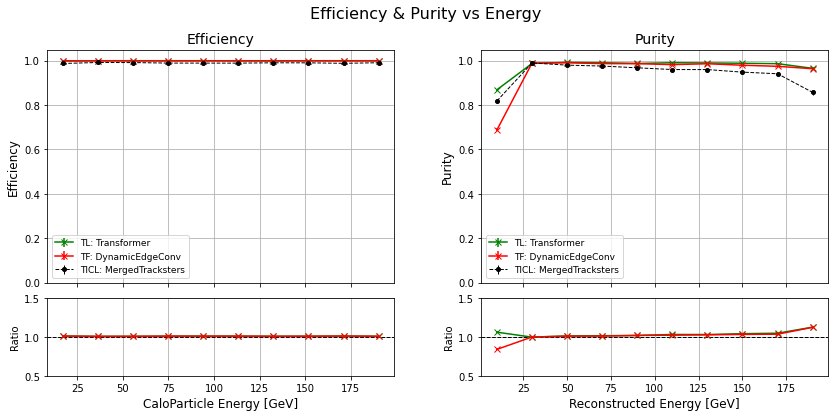

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Assume the following DataFrames are already loaded:
#    Efficiency DataFrames: df_Trans, df_MT, df_DEC
#    Electron/Pion DataFrames: df_Trans_e, df_MT_e, df_DEC_e
# --------------------------------------------------------------------

# --------------------------------------------------------------------
# 2. Prepare data for EFFICIENCY (Mix DataFrames)
# --------------------------------------------------------------------
# Build a dictionary with the new keys.
# NOTE: The ordering here is set so that TL: Transformer comes first,
# then TF: DynamicEdgeConv, and finally TICL: MergedTracksters.
model_dfs_all = {
    "TL: Transformer": df_Trans,
    "TF: DynamicEdgeConv": df_DEC,
    "TICL: MergedTracksters": df_MT
}

# Cast numeric columns and filter for pgid in [11, -11]
for name, df in model_dfs_all.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    model_dfs_all[name] = df[df['pgid'].isin([11, -11])]

def prepare_cp_data(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max'
    }).reset_index()
    # Define "reco" if shared energy is at least 50% of the cp energy
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Process each efficiency DataFrame.
model_prepared_all = {name: prepare_cp_data(df) for name, df in model_dfs_all.items()}

# Define efficiency binning
all_energies = pd.concat([df['cp_energy'] for df in model_prepared_all.values()])
min_energy = all_energies.min()
max_energy = 200
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

# Assign energy bins to each DataFrame.
for df in model_prepared_all.values():
    df['energy_bin'] = pd.cut(df['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

def aggregate_efficiency(df):
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

# Compute efficiency aggregates for each model.
eff_all = {name: aggregate_efficiency(df) for name, df in model_prepared_all.items()}

# Build final dictionary for efficiency curves in desired order.
model_efficiency = {
    "TL: Transformer": eff_all["TL: Transformer"],
    "TF: DynamicEdgeConv": eff_all["TF: DynamicEdgeConv"],
    "TICL: MergedTracksters": eff_all["TICL: MergedTracksters"]
}

# --------------------------------------------------------------------
# 3. Prepare data for PURITY (Electron/Pion DataFrames)
# --------------------------------------------------------------------
model_dfs_e_all = {
    "TL: Transformer": df_Trans_e,
    "TF: DynamicEdgeConv": df_DEC_e,
    "TICL: MergedTracksters": df_MT_e
}

def prepare_trackster_data(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    # Define association if the minimum reco-to-sim score is less than 0.2
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Process electron/pion DataFrames.
prepared_dfs_e_all = {name: prepare_trackster_data(df) for name, df in model_dfs_e_all.items()}

# Define purity binning
all_energies_e = pd.concat([df['trackster_energy'] for df in prepared_dfs_e_all.values()])
min_energy_e = all_energies_e.min()
max_energy_e = 200
n_bins_e = 10
energy_bins_e = np.linspace(min_energy_e, max_energy_e, n_bins_e + 1)
bin_centers_e = 0.5 * (energy_bins_e[:-1] + energy_bins_e[1:])

# Assign energy bins for each electron DataFrame.
for df in prepared_dfs_e_all.values():
    df['energy_bin'] = pd.cut(df['trackster_energy'], bins=energy_bins_e, labels=False, include_lowest=True)

def aggregate_purity(df):
    agg = df.groupby('energy_bin').agg(
        total_ts=('trackster_energy', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    # Reindex to ensure every bin is present
    return agg.set_index('energy_bin').reindex(range(n_bins_e)).reset_index()

# Compute purity aggregates.
pur_all = {name: aggregate_purity(df) for name, df in prepared_dfs_e_all.items()}

# Build final dictionary for purity curves in desired order.
model_purity = {
    "TL: Transformer": pur_all["TL: Transformer"],
    "TF: DynamicEdgeConv": pur_all["TF: DynamicEdgeConv"],
    "TICL: MergedTracksters": pur_all["TICL: MergedTracksters"]
}

# --------------------------------------------------------------------
# 4. Build the figure: Two columns for Efficiency and Purity with
#    top subplots (absolute values) and ratio subplots.
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# -----------------------
# LEFT COLUMN: Efficiency
# -----------------------
left_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_eff = fig.add_subplot(left_gs[0])
ax_eff_ratio = fig.add_subplot(left_gs[1], sharex=ax_eff)

# Define colors for efficiency curves in desired order.
eff_colors = {
    "TL: Transformer": "green",
    "TF: DynamicEdgeConv": "red",
    "TICL: MergedTracksters": "black"
}

# Plot efficiency curves.
for key, agg in model_efficiency.items():
    if key == "TICL: MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        linewidth = 1
        markersize = 4
    else:
        marker_style = "x"
        linestyle = "-"
        linewidth = 1.5
        markersize = 6
    ax_eff.errorbar(
        bin_centers, agg['efficiency'],
        yerr=agg['eff_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=eff_colors[key]
    )

ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)  # Legend now will follow the dictionary order
ax_eff.grid(True)
ax_eff.set_title('Efficiency', fontsize=14)

# Efficiency ratio plot: (non-reference curves divided by TICL: MergedTracksters)
ref_key_eff = "TICL: MergedTracksters"
ref_eff = model_efficiency[ref_key_eff]
ref_eff_val = ref_eff['efficiency'].replace(0, np.nan)
ref_eff_err = ref_eff['eff_error']

for key, agg in model_efficiency.items():
    if key == ref_key_eff:
        continue
    marker_style = "x"
    linestyle = "-"
    ratio = agg['efficiency'] / ref_eff_val
    ratio_err = ratio * np.sqrt((agg['eff_error']/agg['efficiency'])**2 + (ref_eff_err/ref_eff_val)**2)
    ax_eff_ratio.errorbar(
        bin_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=1.5, markersize=6,
        color=eff_colors[key]
    )

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('CaloParticle Energy [GeV]', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0.5, 1.5)
ax_eff_ratio.grid(True)

# ------------------------
# RIGHT COLUMN: Purity
# ------------------------
right_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_purity = fig.add_subplot(right_gs[0])
ax_purity_ratio = fig.add_subplot(right_gs[1], sharex=ax_purity)

# Define colors for purity curves in desired order.
pur_colors = {
    "TL: Transformer": "green",
    "TF: DynamicEdgeConv": "red",
    "TICL: MergedTracksters": "black"
}

# Plot purity curves.
for key, agg in model_purity.items():
    if key == "TICL: MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        linewidth = 1
        markersize = 4
    else:
        marker_style = "x"
        linestyle = "-"
        linewidth = 1.5
        markersize = 6
    ax_purity.errorbar(
        bin_centers_e, agg['purity'],
        yerr=agg['purity_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=pur_colors[key]
    )

ax_purity.tick_params(labelbottom=False)
ax_purity.set_ylabel('Purity', fontsize=12)
ax_purity.set_ylim(0, 1.05)
ax_purity.legend(fontsize=9)
ax_purity.grid(True)
ax_purity.set_title('Purity', fontsize=14)

# Purity ratio plot: (non-reference curves divided by TICL: MergedTracksters)
ref_key_pur = "TICL: MergedTracksters"
ref_pur = model_purity[ref_key_pur]
ref_pur_val = ref_pur['purity'].replace(0, np.nan)
ref_pur_err = ref_pur['purity_error']

for key, agg in model_purity.items():
    if key == ref_key_pur:
        continue
    marker_style = "x"
    linestyle = "-"
    ratio = agg['purity'] / ref_pur_val
    ratio_err = ratio * np.sqrt((agg['purity_error']/agg['purity'])**2 + (ref_pur_err/ref_pur_val)**2)
    ax_purity_ratio.errorbar(
        bin_centers_e, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=1.5, markersize=6,
        color=pur_colors[key]
    )

ax_purity_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_purity_ratio.set_xlabel('Reconstructed Energy [GeV]', fontsize=12)
ax_purity_ratio.set_ylabel('Ratio', fontsize=10)
ax_purity_ratio.set_ylim(0.5, 1.5)
ax_purity_ratio.grid(True)

plt.suptitle('Efficiency & Purity vs Energy', fontsize=16)
plt.show()


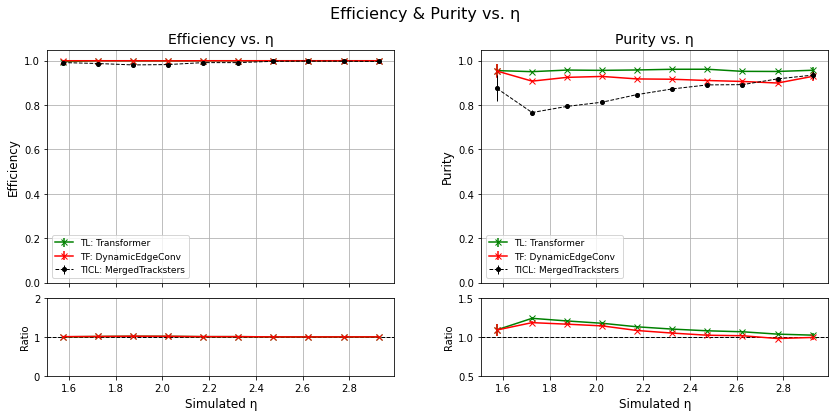

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Prepare Efficiency vs. η from CaloParticle Data
# --------------------------------------------------------------------
# Build a temporary dictionary for the three models.
model_dfs_all = {
    "TL: Transformer": df_Trans,
    "TF: DynamicEdgeConv": df_DEC,
    "TICL: MergedTracksters": df_MT
}

# Cast numeric columns and filter rows based on pgid in [211, -211]
for name, df in model_dfs_all.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')
    model_dfs_all[name] = df[df['pgid'].isin([11, -11])]

# Function to prepare CaloParticle data (including η)
def prepare_cp_data(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'cp_eta': 'first',
        'shared_energy': 'max'
    }).reset_index()
    # A CaloParticle is considered reconstructed if its shared_energy 
    # is at least 70% of its cp_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Process all mix data.
model_prepared_all = {name: prepare_cp_data(df) for name, df in model_dfs_all.items()}

# Define η binning from 1.5 to 3.0 in 10 bins.
min_eta = 1.5
max_eta = 3.0
n_eta_bins = 10
eta_bins = np.linspace(min_eta, max_eta, n_eta_bins + 1)
eta_centers = (eta_bins[:-1] + eta_bins[1:]) / 2

# Assign η bins to each DataFrame.
for df in model_prepared_all.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

# Aggregate efficiency versus η.
def aggregate_efficiency_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all = {name: aggregate_efficiency_eta(df) for name, df in model_prepared_all.items()}

# Build the final efficiency dictionary.
model_efficiency_eta = {
    "TL: Transformer": eff_all["TL: Transformer"],
    "TF: DynamicEdgeConv": eff_all["TF: DynamicEdgeConv"],
    "TICL: MergedTracksters": eff_all["TICL: MergedTracksters"]
}

# --------------------------------------------------------------------
# 2. Prepare Purity vs. η from Electron Trackster Data
# --------------------------------------------------------------------
# Build a dictionary with the electron trackster DataFrames for the three models.
model_dfs_e_all = {
    "TL: Transformer": df_Trans_e,
    "TF: DynamicEdgeConv": df_DEC_e,
    "TICL: MergedTracksters": df_MT_e
}

# Assume each electron trackster file provides a measurement of cp_eta.
def prepare_trackster_data_eta(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'cp_eta': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    # For purity, define "associated" if the reco_to_sim_score is below 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Process electron data.
model_prepared_e = {name: prepare_trackster_data_eta(df) for name, df in model_dfs_e_all.items()}

# Assign the same η bins as above.
for df in model_prepared_e.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

# Aggregate purity versus η.
def aggregate_purity_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_ts=('cp_eta', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_eta = {name: aggregate_purity_eta(df) for name, df in model_prepared_e.items()}

# Build the final purity dictionary.
model_purity_eta = {
    "TL: Transformer": pur_all_eta["TL: Transformer"],
    "TF: DynamicEdgeConv": pur_all_eta["TF: DynamicEdgeConv"],
    "TICL: MergedTracksters": pur_all_eta["TICL: MergedTracksters"]
}

# --------------------------------------------------------------------
# 3. Build the Figure: Efficiency and Purity vs. η (side by side)
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
# Create two columns: left for efficiency and right for purity.
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# ----- Left Column: Efficiency vs. η -----
eff_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_eff = fig.add_subplot(eff_gs[0])
ax_eff_ratio = fig.add_subplot(eff_gs[1], sharex=ax_eff)

# Define colors and marker styles for efficiency.
eff_colors = {
    "TL: Transformer": "green",
    "TF: DynamicEdgeConv": "red",
    "TICL: MergedTracksters": "black"
}
ordered_eff_keys = ["TL: Transformer", "TF: DynamicEdgeConv", "TICL: MergedTracksters"]

for key in ordered_eff_keys:
    agg = model_efficiency_eta[key]
    if key == "TICL: MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        linewidth = 1
        markersize = 4
    else:
        marker_style = "x"
        linestyle = "-"
        linewidth = 1.5
        markersize = 6
    ax_eff.errorbar(
        eta_centers, agg['efficiency'],
        yerr=agg['eff_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=eff_colors[key]
    )

ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)
ax_eff.grid(True)
ax_eff.set_title('Efficiency vs. η', fontsize=14)

# Efficiency ratio: each curve divided by TICL: MergedTracksters.
ref_key_eff = "TICL: MergedTracksters"
ref_eff = model_efficiency_eta[ref_key_eff]
ref_val_eff = ref_eff['efficiency'].replace(0, np.nan)
ref_err_eff = ref_eff['eff_error']

for key in ordered_eff_keys:
    if key == ref_key_eff:
        continue
    agg = model_efficiency_eta[key]
    marker_style = "x"
    linestyle = "-"
    linewidth = 1.5
    markersize = 6
    ratio = agg['efficiency'] / ref_val_eff
    ratio_err = ratio * np.sqrt((agg['eff_error'] / agg['efficiency'])**2 + (ref_err_eff / ref_val_eff)**2)
    ax_eff_ratio.errorbar(
        eta_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        color=eff_colors[key]
    )

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('Simulated η', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0, 2.0)
ax_eff_ratio.grid(True)

# ----- Right Column: Purity vs. η -----
pur_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_pur = fig.add_subplot(pur_gs[0])
ax_pur_ratio = fig.add_subplot(pur_gs[1], sharex=ax_pur)

pur_colors = {
    "TL: Transformer": "green",
    "TF: DynamicEdgeConv": "red",
    "TICL: MergedTracksters": "black"
}
ordered_pur_keys = ordered_eff_keys

for key in ordered_pur_keys:
    agg = model_purity_eta[key]
    if key == "TICL: MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        linewidth = 1
        markersize = 4
    else:
        marker_style = "x"
        linestyle = "-"
        linewidth = 1.5
        markersize = 6
    ax_pur.errorbar(
        eta_centers, agg['purity'],
        yerr=agg['purity_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=pur_colors[key]
    )

ax_pur.tick_params(labelbottom=False)
ax_pur.set_ylabel('Purity', fontsize=12)
ax_pur.set_ylim(0, 1.05)
ax_pur.legend(fontsize=9)
ax_pur.grid(True)
ax_pur.set_title('Purity vs. η', fontsize=14)

ref_key_pur = "TICL: MergedTracksters"
ref_pur = model_purity_eta[ref_key_pur]
ref_val_pur = ref_pur['purity'].replace(0, np.nan)
ref_err_pur = ref_pur['purity_error']

for key in ordered_pur_keys:
    if key == ref_key_pur:
        continue
    agg = model_purity_eta[key]
    marker_style = "x"
    linestyle = "-"
    linewidth = 1.5
    markersize = 6
    ratio = agg['purity'] / ref_val_pur
    ratio_err = ratio * np.sqrt((agg['purity_error'] / agg['purity'])**2 + (ref_err_pur / ref_val_pur)**2)
    ax_pur_ratio.errorbar(
        eta_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        color=pur_colors[key]
    )

ax_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_pur_ratio.set_xlabel('Simulated η', fontsize=12)
ax_pur_ratio.set_ylabel('Ratio', fontsize=10)
ax_pur_ratio.set_ylim(0.5, 1.5)
ax_pur_ratio.grid(True)

plt.suptitle('Efficiency & Purity vs. η', fontsize=16)
plt.show()


/tmp/ipykernel_3385630/1700025729.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_3385630/1700025729.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_3385630/1700025729.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

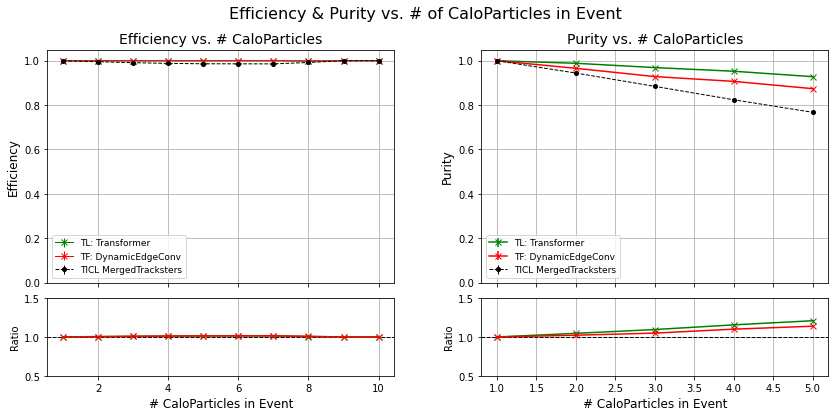

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Prepare Efficiency vs. # of CaloParticles in the event
# --------------------------------------------------------------------
# Build a dictionary for the three models.
model_dfs_all = {
    "TL: Transformer": df_Trans,
    "TF: DynamicEdgeConv": df_DEC,
    "TICL MergedTracksters": df_MT
}

# Cast columns to numeric and filter for pgid in [211, -211]
for name, df in model_dfs_all.items():
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    df = df[df['pgid'].isin([11, -11])]
    
    # For each event, add a column with the number of unique cp_id's.
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
    
    # Group by (event_index, cp_id) to have one row per CaloParticle (with its event's CP count)
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max',
        'n_cp': 'first'
    }).reset_index()
    
    # Mark the CP as reconstructed if shared_energy is at least 80% of cp_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    
    model_dfs_all[name] = grouped

# Function to aggregate efficiency vs. number of CaloParticles (n_cp)
def aggregate_efficiency_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_cp=('cp_id', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all = {name: aggregate_efficiency_ncp(df) for name, df in model_dfs_all.items()}

# Build final efficiency dictionary with our three models.
model_efficiency_ncp = {
    "TL: Transformer": eff_all["TL: Transformer"],
    "TF: DynamicEdgeConv": eff_all["TF: DynamicEdgeConv"],
    "TICL MergedTracksters": eff_all["TICL MergedTracksters"]
}

# --------------------------------------------------------------------
# 2. Prepare Purity vs. # of CaloParticles in the event (from Electron Trackster Data)
# --------------------------------------------------------------------
# Build a dictionary for the three models.
model_dfs_e_all = {
    "TL: Transformer": df_Trans_e,
    "TF: DynamicEdgeConv": df_DEC_e,
    "TICL MergedTracksters": df_MT_e
}

def prepare_trackster_data_ncp(df):
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    
    # For each event, add the number of unique cp_id's
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
    
    # Group by (event_index, trackster_id)
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'reco_to_sim_score': 'min',
        'n_cp': 'first'
    }).reset_index()
    
    # Define an association if reco_to_sim_score is below 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

model_prepared_e_all = {name: prepare_trackster_data_ncp(df) for name, df in model_dfs_e_all.items()}

def aggregate_purity_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_ts=('trackster_id', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all = {name: aggregate_purity_ncp(df) for name, df in model_prepared_e_all.items()}

model_purity_ncp = {
    "TL: Transformer": pur_all["TL: Transformer"],
    "TF: DynamicEdgeConv": pur_all["TF: DynamicEdgeConv"],
    "TICL MergedTracksters": pur_all["TICL MergedTracksters"]
}

# --------------------------------------------------------------------
# 3. Build the Figure: Efficiency and Purity vs. # of CaloParticles in Event
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# ----- Left Column: Efficiency vs. n_cp -----
eff_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_eff = fig.add_subplot(eff_gs[0])
ax_eff_ratio = fig.add_subplot(eff_gs[1], sharex=ax_eff)

# Define colors and marker styles for efficiency.
eff_colors = {
    "TL: Transformer": "green",
    "TF: DynamicEdgeConv": "red",
    "TICL MergedTracksters": "black"
}
ordered_eff_keys = ["TL: Transformer", "TF: DynamicEdgeConv", "TICL MergedTracksters"]

for key in ordered_eff_keys:
    df_agg = model_efficiency_ncp[key].sort_values('n_cp')
    xvals = df_agg['n_cp']
    yvals = df_agg['efficiency']
    yerr  = df_agg['eff_error']
    
    # Use a different marker & linestyle for TICL MergedTracksters
    if key == "TICL MergedTracksters":
        marker_style = "o"
        ls = "--"
        lw = 1
        ms = 4
    else:
        marker_style = "x"
        ls = "-"
        lw = 1
        ms = 6
    ax_eff.errorbar(xvals, yvals, yerr=yerr,
                    marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                    label=key, color=eff_colors[key])

ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)
ax_eff.grid(True)
ax_eff.set_title('Efficiency vs. # CaloParticles', fontsize=14)

# Efficiency Ratio Plot (normalized to TICL MergedTracksters)
ref_key_eff = "TICL MergedTracksters"
ref_df_eff = model_efficiency_ncp[ref_key_eff].sort_values('n_cp')
for key in ordered_eff_keys:
    if key == ref_key_eff:
        continue
    df_agg = model_efficiency_ncp[key].sort_values('n_cp')
    # Merge by n_cp to compute the ratio at each bin.
    merged = pd.merge(df_agg, ref_df_eff, on='n_cp', suffixes=('', '_ref'))
    xvals  = merged['n_cp']
    num_val  = merged['efficiency']
    num_err  = merged['eff_error']
    den_val  = merged['efficiency_ref'].replace(0, np.nan)
    den_err  = merged['eff_error_ref']
    
    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)
    
    marker_style = "x"
    ls = "-"
    lw = 1.5
    ms = 6
    ax_eff_ratio.errorbar(xvals, ratio, yerr=ratio_err,
                          marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                          color=eff_colors[key])

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('# CaloParticles in Event', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0.5, 1.5)
ax_eff_ratio.grid(True)

# ----- Right Column: Purity vs. n_cp -----
pur_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_pur = fig.add_subplot(pur_gs[0])
ax_pur_ratio = fig.add_subplot(pur_gs[1], sharex=ax_pur)

pur_colors = {
    "TL: Transformer": "green",
    "TF: DynamicEdgeConv": "red",
    "TICL MergedTracksters": "black"
}
ordered_pur_keys = ordered_eff_keys

for key in ordered_pur_keys:
    df_agg = model_purity_ncp[key].sort_values('n_cp')
    xvals = df_agg['n_cp']
    yvals = df_agg['purity']
    yerr  = df_agg['purity_error']
    
    if key == "TICL MergedTracksters":
        marker_style = "o"
        ls = "--"
        lw = 1
        ms = 4
    else:
        marker_style = "x"
        ls = "-"
        lw = 1.5
        ms = 6
    ax_pur.errorbar(xvals, yvals, yerr=yerr,
                    marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                    label=key, color=pur_colors[key])

ax_pur.tick_params(labelbottom=False)
ax_pur.set_ylabel('Purity', fontsize=12)
ax_pur.set_ylim(0, 1.05)
ax_pur.legend(fontsize=9)
ax_pur.grid(True)
ax_pur.set_title('Purity vs. # CaloParticles', fontsize=14)

# Purity Ratio Plot (normalized to TICL MergedTracksters)
ref_key_pur = "TICL MergedTracksters"
ref_df_pur = model_purity_ncp[ref_key_pur].sort_values('n_cp')
for key in ordered_pur_keys:
    if key == ref_key_pur:
        continue
    df_agg = model_purity_ncp[key].sort_values('n_cp')
    merged = pd.merge(df_agg, ref_df_pur, on='n_cp', suffixes=('', '_ref'))
    xvals  = merged['n_cp']
    num_val  = merged['purity']
    num_err  = merged['purity_error']
    den_val  = merged['purity_ref'].replace(0, np.nan)
    den_err  = merged['purity_error_ref']
    
    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)
    
    marker_style = "x"
    ls = "-"
    lw = 1.5
    ms = 6
    ax_pur_ratio.errorbar(xvals, ratio, yerr=ratio_err,
                          marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                          color=pur_colors[key])

ax_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_pur_ratio.set_xlabel('# CaloParticles in Event', fontsize=12)
ax_pur_ratio.set_ylabel('Ratio', fontsize=10)
ax_pur_ratio.set_ylim(0.5, 1.5)
ax_pur_ratio.grid(True)

plt.suptitle('Efficiency & Purity vs. # of CaloParticles in Event', fontsize=16)
plt.show()
